## Import modules

In [2]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

#import pickle5 as pickle

## Load data, using half of the dataset to train

In [3]:
data = pd.read_hdf("data.h5", 'df')
# with open("data.h5", "rb") as fh:
#    data = pickle.load(fh)
# data = pd.read_csv("data.csv")
train_df, test_df = train_test_split(data, test_size=0.5)
test_df, CV_df = train_test_split(test_df, test_size=0.5)
# validation used to keep track of training set; monitor accuracy

In [6]:
print("len train_df: " + str(len(train_df)))
train_df.head(5)

len train_df: 604


,id,ai,eta,truetracklen
339,p352_90,"[55, 70, 85, 115, 130, 145, 160, 175, 190, 205...","[549.979, 6141.78, 2927.22, 2664.52, 1690.91, ...",279.411
507,p471_72,"[55, 70, 85, 100, 115, 130, 145, 160, 175, 190...","[113.766, 3444.64, 80.6464, 1088.76, 155.256, ...",130.899
38,p126_92,"[55, 70, 85, 100, 115, 130, 145, 160, 175, 190...","[523.61, 78.415, 353.359, 1070.21, 453.389, 36...",124.875
603,p537_31,"[55, 85, 100, 115, 130, 145, 160, 175, 190, 20...","[714.337, 92.9009, 348.44, 174.965, 122.869, 1...",102.840
44,p130_81,"[70, 85, 100, 115, 130, 145, 160, 175, 190, 20...","[4292.69, 1344.93, 1273.87, 3812.56, 2661.19, ...",258.010


In [7]:
print("len test_df: " + str(len(test_df)))
test_df.head(5)

len test_df: 302


,id,ai,eta,truetracklen
32,p123_32,"[55, 70, 85, 115, 130, 145, 160, 175, 190, 205...","[7597.66, 2931.41, 1974.74, 2571.86, 1708.39, ...",242.811
1174,p971_4,"[70, 85, 100, 115, 130, 145, 175, 190, 205, 22...","[357.155, 123.131, 360.478, 1152.24, 361.963, ...",110.138
174,p247_12,"[70, 85, 115, 130, 145, 160, 175, 190, 205, 22...","[916.48, 491.517, 2365.18, 2055.48, 3480.74, 2...",181.154
211,p270_93,"[55, 85, 100, 115, 130, 145, 160, 175, 190, 20...","[2984.55, 1725.78, 545.904, 742.709, 214.007, ...",159.250
906,p772_85,"[70, 100, 115, 130, 145, 160, 175, 190, 205, 2...","[1992.67, 2290.85, 2715.54, 2707.41, 784.16, 2...",205.670


In [8]:
print("len CV_df: " + str(len(CV_df)))
CV_df.head(5)

len CV_df: 302


,id,ai,eta,truetracklen
81,p164_94,"[55, 85, 100, 115, 130, 145, 160, 175, 190, 20...","[5023.45, 4350.31, 2219.58, 3430.22, 1382.1, 2...",236.936
375,p374_55,"[70, 85, 115, 130, 145, 160, 175, 190, 205, 22...","[2466.16, 1189.26, 1778.43, 1615.0, 541.724, 4...",153.380
841,p720_61,"[55, 85, 100, 115, 130, 145, 160, 175, 190, 20...","[2373.42, 232.338, 2157.95, 366.297, 1712.65, ...",159.559
342,p355_16,"[70, 85, 100, 115, 130, 145, 160, 175, 205, 22...","[381.968, 663.304, 150.795, 1079.38, 1079.35, ...",121.055
246,p294_64,"[55, 70, 85, 115, 130, 160, 175, 190, 205, 220...","[898.158, 1093.47, 2163.42, 1260.83, 1772.65, ...",177.256


In [4]:
print(data[data['truetracklen'] < 0.])

Empty DataFrame
Columns: [id, ai, eta, truetracklen]
Index: []


## Define MyDataset class

In [9]:
class MyDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        evid = self.data.iloc[idx,0]    #added to include evid in output file
        features = torch.tensor(self.data.iloc[idx, 1:-1], dtype=torch.float32)
        features = features.t()
        target = torch.tensor(self.data.iloc[idx, -1], dtype=torch.float32)
        return evid, features, target   #added evid as return value


In [10]:
batch_size = 1 # Adjust batch size as needed
# sequence_length = 3  # Adjust sequence length as needed
shuffle = True  # Shuffle the data during training (recommended)
dataS = MyDataset(data)
train = MyDataset(train_df)
test = MyDataset(test_df)
CVS = MyDataset(CV_df)
trainloader = DataLoader(train, batch_size=1, shuffle=shuffle) #how much data to train per epoch
testloader = DataLoader(test)
dataloader = DataLoader(dataS, batch_size=1, shuffle=shuffle)
CVloader = DataLoader(CVS)

In [22]:
print(dataloader)

## Define ManyToOneRNN class

In [11]:
class ManyToOneRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(ManyToOneRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True,nonlinearity='relu')
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate the RNN
        out, _ = self.rnn(x,h0)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [15]:
cost_list = []
CVcost_list = []
input_size = 2
hidden_size = 4
num_layers = 1
output_size = 1
learning_rate = 0.001   #can tune this for better model
num_epochs = 1000   #default:10000

model = ManyToOneRNN(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

N = 100    #for printing progress

In [16]:
def train():
    model.train()

    for epoch in range(num_epochs):
        COST=0
        CVCost = 0
        i = 0
        for ev,dat,target in trainloader:  # Iterate in batches over the training dataset.; EDIT: added ev
            out = model(dat)  # Perform a single forward pass.
            loss = criterion(out, target)  # Compute the loss.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.
            optimizer.zero_grad()  # Clear gradients.
            COST += loss.data
            i += 1
            # if epoch % 100 == 0 and i ==1 :
                # print("loss is {}".format(loss.data))
                # print("target value is {}".format(target))
                # print("out is {}".format(out))

        cost_list.append(COST)

        #perform a prediction on the validation  data
        for CVID,CVD,CVT in CVloader:

            with torch.no_grad():
               CVout = model(CVD)
            loss = criterion(CVout, CVT)

            CVCost += loss

        CVcost_list.append(CVCost)

        if epoch%N == 0:
            print("epoch number:{}".format(epoch))
            print("validation MSE is {}".format(COST))
            print("train MSE is {}".format(CVCost))


## Train model

In [17]:
tstart=time.time()
print("start time={}".format(tstart))
train()
torch.save(model, 'model.pth')

print((time.time()-tstart))

start time=1712530487.231816
epoch number:0
validation MSE is 4674168.5
train MSE is 721203.625
epoch number:100
validation MSE is 220126.5625
train MSE is 169800.484375
epoch number:200
validation MSE is 193258.09375
train MSE is 140528.84375
epoch number:300
validation MSE is 165590.21875
train MSE is 125440.28125
epoch number:400
validation MSE is 169457.296875
train MSE is 123987.2578125
epoch number:500
validation MSE is 163948.609375
train MSE is 130581.4296875
epoch number:600
validation MSE is 173583.328125
train MSE is 112238.53125
epoch number:700
validation MSE is 157435.203125
train MSE is 103951.34375
epoch number:800
validation MSE is 142474.953125
train MSE is 138760.046875
epoch number:900
validation MSE is 142750.671875
train MSE is 100356.3203125
2341.0533590316772


### Plot the loss and accuracy

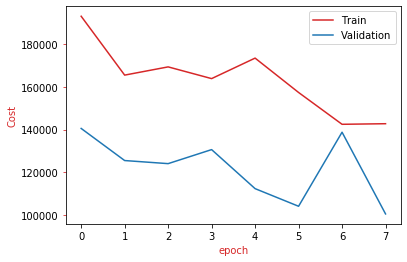

In [18]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list[200::100], color=color,label="Train")
ax1.plot(CVcost_list[200::100], color='tab:blue',label="Validation")
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
ax1.legend()

# want red and blue to be close and cost to be low

In [19]:
def test(loader):
    model.eval()

    #open output file for fitted track length
    out_f = open("fitbyeye_wcsim_RNN.txt", "a")
    
    diff_list = []
    for evid,data,target in loader:  # Iterate in batches over the training/test dataset.
        with torch.no_grad():
            out = model(data)   # just need this for data
            diff = out - target  # Use the class with highest probability.
            #print(evid[0], out.data.numpy()[0][0], target.data.numpy()[0])   #evid, fit, truelen
            #print(diff)
            out_f.write(str(evid[0]) + "," + str(out.data.numpy()[0][0]) + "\n")
            diff_list.append(diff.data.numpy()[0][0])  # Check against ground-truth labels.
            # diff_list.append(diff.data.numpy())  # Check against ground-truth labels.
    out_f.close()
    return diff_list  # Derive ratio of correct predictions.


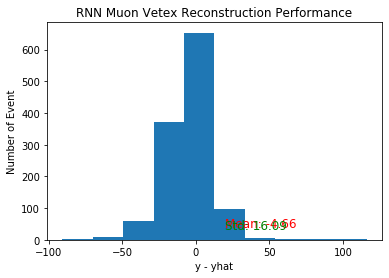

In [20]:
diff_list = test(dataloader)



plt.hist(diff_list)

mean = np.mean(diff_list)
std = np.std(diff_list)

# custom_labels = ['Mean is {}'.format(mean), 'Std is {}'.format(std)]

# Add a legend with custom labels
plt.text(20, 40, f'Mean: {mean:.2f}', fontsize=12, color='red')
plt.text(20, 35, f'Std: {std:.2f}', fontsize=12, color='green')


plt.xlabel("y - yhat")
plt.ylabel("Number of Event")
plt.title("RNN Muon Vetex Reconstruction Performance")
# plt.legend(custom_labels)
plt.savefig("RNN.png")

In [21]:
print("mean: ",mean)
print("std: " + str(std))

mean:  -4.6632338
std: 16.087687


## Save the model

In [ ]:
#torch.save or model.save
#load model in another script and just use